# Generating the paper figures 
Cedric Chauve, November 20, 2018

In [1]:
import sys
sys.path.append('../../scripts')
import TreeConflict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

## Overview

This notebook contains an analysis of the results of the experiments consisting into 
* simulating the evolution of genomes (gene trees and gene orders) using <a href="https://www.biorxiv.org/content/early/2018/06/07/339473">Zombi</a>;
* adding noise by performing NNI tree rearrangements, with various levels of noise;
* reconstructing ancestral adjacencies using <a href="https://doi.org/10.1093/gbe/evx069">DeCoSTAR</a>;
* recording statistics about the scores of reconciliation, DeCoSTAR and linearity of ancestral gene orders
in order to assess if the linearity of ancestral gene orders can be used as a diagnostic measure of correctness of the gene trees.

The experiments were run on two datasets of simulated gene trees, one simulated with no HGT and one simulated with HGT, respectively called the Dataset 1 and the Dataset 2.

## Data and results

The data and results of the experiments for the Dataset 1 are available in the directory ../../exp/2018_07_15_D10T0L20I10T10_NNI_DECOSTAR.  

The data and results of the experiments for the Dataset 2 are available in the directory ../../exp/2018_07_16_D10T10L20I10T10_NNI_DECOSTAR. 

In a second time we used a modified species tree, differing from the true tree by a single NNI. For Dataset 1, the results are available at ../../exp/2018_08_09_D10T0L20I10T10_NNI_DECOSTAR_ST1. For Dataset 2, the results are available at ../../exp/2018_08_09_D10T10L20I10T10_NNI_DECOSTAR_ST1.

In each of these directory, a summary file of the results is available in the file results/summary_1.

In [2]:
# Correspondance between dataset names and LAMBDA2VAL parameter of the Poisson law used to determine the average number of NNI per gene tree
LAMBDA2VAL = {'lambda_025':0.25,'lambda_05':0.5,'lambda_1':1,'lambda_2':2,'lambda_3':3,'lambda_5':5,'lambda_7':7,'lambda_10':10,'lambda_20':20,'lambda_30':30,'lambda_50'
:50}
LAMBDA     = ['lambda_025','lambda_05','lambda_1','lambda_2','lambda_3','lambda_5','lambda_7','lambda_10','lambda_20','lambda_30','lambda_50']
TRUE       = 'true trees' # Label of the tick corresponding to true trees in figures
TLAMBDA    = [TRUE]+LAMBDA

In [3]:
def read_summary_file(F):
    SUMMARY_FILE = open(F,'r').readlines()
    SUMMARY_AUX  = {}
    for l in SUMMARY_FILE:
        if l[0]!="#":
            l1 = l.rstrip().split()
            (name,plambda,rf,gdup,gloss,hgt,rec,again,abreak,deco,linearity) = (l1[0],float(LAMBDA2VAL[l1[0]]),float(l1[1]),float(l1[2]),float(l1[3]),float(l1[4]),float(l1[5]),float(l1[6]),float(l1[7]),float(l1[8]),float(l1[9]))
            SUMMARY_AUX[name] = (plambda,rf,gdup,gloss,hgt,rec,again,abreak,deco,linearity)  
    SUMMARY = pd.DataFrame.transpose(pd.DataFrame(SUMMARY_AUX))
    SUMMARY.columns=['Lambda','RF','nb_dup','nb_loss','nb_hgt','rec_score','nb_gain','nb_break','DeCo_score','linearity_score']
    return(SUMMARY)

def get_ancestral_species(F,virtual_root):
    data = open(F,'r').readlines()
    ancestral_species = []
    for gene in data:
        gene1     = gene.rstrip().split()
        species   = gene1[0]
        gene_name = gene1[1]
        if '|' in gene_name and not species in ancestral_species:
            ancestral_species.append(species)
    if virtual_root in ancestral_species:
        ancestral_species.remove(virtual_root)
    return(ancestral_species)

def count_gene_content(prefix,true_trees,ancestral_species):
    # Gene content of the perturbed tree
    gene_content = {l: {species: 0 for species in ancestral_species} for l in TLAMBDA}
    for L in LAMBDA:
        data = open(prefix+'/'+L+'/'+L+'.genes.txt','r').readlines()
        for gene in data:
            species = gene.split()[0]
            if species in ancestral_species:
                gene_content[L][species] += 1
    # Gene content of the true trees
    data = open(true_trees,'r').readlines()
    for gene in data:
        species = gene.split()[0]
        if species in ancestral_species:
            gene_content[TRUE][species] += 1
    return(gene_content) 

def measure_linearity(prefix,prefix_true_trees,ancestral_species):
    # Linearity of the perturbed tree
    ngbs = {l: {species: {} for species in ancestral_species} for l in TLAMBDA}
    for L in LAMBDA:
        data = open(prefix+'/'+L+'/'+L+'.genes.txt','r').readlines()
        for gene in data:
            species = gene.split()[0]
            name    = gene.split()[1]
            if species in ancestral_species:
                ngbs[L][species][name] = []
    data = open(prefix_true_trees+'.genes.txt','r').readlines()
    for gene in data:
        species = gene.split()[0]
        name    = gene.split()[1]
        if species in ancestral_species:
            ngbs[TRUE][species][name] = []
    for L in LAMBDA:
        data = open(prefix+'/'+L+'/'+L+'.adjacencies.txt','r').readlines()
        for gene in data:
            species = gene.split()[0]
            name1   = gene.split()[1]
            name2   = gene.split()[2]
            if species in ancestral_species:
                ngbs[L][species][name1].append(name2)
                ngbs[L][species][name2].append(name1)
    data = open(prefix_true_trees+'.adjacencies.txt','r').readlines()
    for gene in data:
        species = gene.split()[0]
        name1   = gene.split()[1]
        name2   = gene.split()[2]
        if species in ancestral_species:
            ngbs[TRUE][species][name1].append(name2)
            ngbs[TRUE][species][name2].append(name1)
    linearity = {l: {species: 0 for species in ancestral_species} for l in TLAMBDA}
    for L in TLAMBDA:
        for species in ngbs[L].keys():
            for gene in ngbs[L][species].keys():
                linearity[L][species] += abs(len(ngbs[L][species][gene])-2)
    return(linearity) 

In [4]:
# Reading data and results

DATASET1_SUMMARY     =read_summary_file('../../exp/2018_07_15_D10T0L20I10T10_NNI_DECOSTAR/results/summary_1')
DATASET2_SUMMARY     = read_summary_file('../../exp/2018_07_16_D10T10L20I10T10_NNI_DECOSTAR/results/summary_1')

DATASET1_ST1_SUMMARY = read_summary_file('../../exp/2018_08_09_D10T0L20I10T10_NNI_DECOSTAR_ST1/results/summary_1')
DATASET2_ST1_SUMMARY = read_summary_file('../../exp/2018_08_09_D10T10L20I10T10_NNI_DECOSTAR_ST1/results/summary_1')

DATASET1_ST1_SUMMARY['RF'] = DATASET1_SUMMARY['RF']
DATASET2_ST1_SUMMARY['RF'] = DATASET2_SUMMARY['RF']

DATASET1_ANCSPECIES  = get_ancestral_species('../../decostar_instances/results/notransfers_true_trees.genes.txt','NA')
DATASET2_ANCSPECIES  = get_ancestral_species('../../decostar_instances/results/transfers_true_trees.genes.txt','52')

DATASET1_GENECONTENT = count_gene_content('../../exp/2018_07_15_D10T0L20I10T10_NNI_DECOSTAR/results/DeCoSTAR/','../../decostar_instances/results/notransfers_true_trees.genes.txt',DATASET1_ANCSPECIES)
DATASET2_GENECONTENT = count_gene_content('../../exp/2018_07_16_D10T10L20I10T10_NNI_DECOSTAR/results/DeCoSTAR/','../../decostar_instances/results/transfers_true_trees.genes.txt',DATASET2_ANCSPECIES)

DATASET1_GENECONTENT_2D = []
for L in TLAMBDA:
    DATASET1_GENECONTENT_2D.append(list(DATASET1_GENECONTENT[L].values()))
    
DATASET2_GENECONTENT_2D = []
for L in TLAMBDA:
    DATASET2_GENECONTENT_2D.append(list(DATASET2_GENECONTENT[L].values()))
    
DATASET1_LINEARITY  = measure_linearity('../../exp/2018_07_15_D10T0L20I10T10_NNI_DECOSTAR/results/DeCoSTAR/','../../decostar_instances/results/notransfers_true_trees',DATASET1_ANCSPECIES)
DATASET2_LINEARITY = measure_linearity('../../exp/2018_07_16_D10T10L20I10T10_NNI_DECOSTAR/results/DeCoSTAR/','../../decostar_instances/results/notransfers_true_trees',DATASET2_ANCSPECIES)

DATASET1_LINEARITY_2D = []
for L in TLAMBDA:
    DATASET1_LINEARITY_2D.append(list(DATASET1_LINEARITY[L].values()))
    
DATASET2_LINEARITY_2D = []
for L in TLAMBDA:
    DATASET2_LINEARITY_2D.append(list(DATASET2_LINEARITY[L].values()))

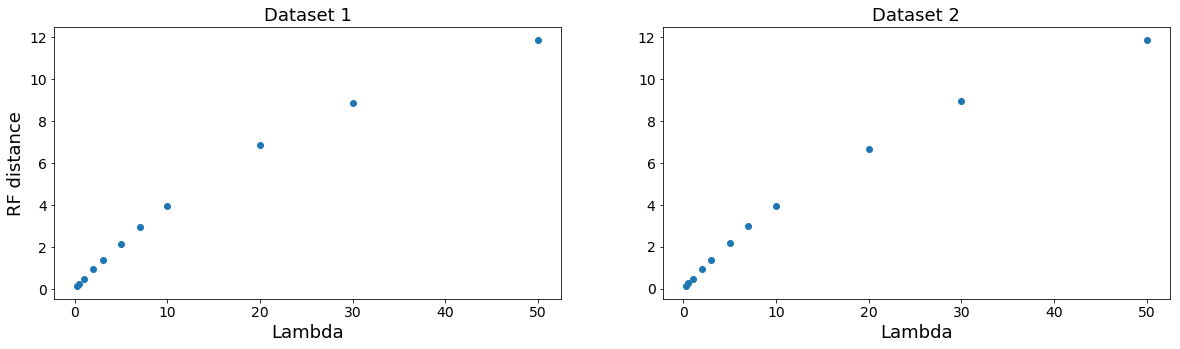

In [5]:
# Figure 2: RF versus lambda

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(DATASET1_SUMMARY['Lambda'], DATASET1_SUMMARY['RF'])
ax[0].set_xlabel("Lambda", fontsize=18)
ax[0].set_ylabel("RF distance", fontsize=18)
ax[0].set_title('Dataset 1', fontsize=18)

ax[1].scatter(DATASET2_SUMMARY['Lambda'], DATASET2_SUMMARY['RF'])
ax[1].set_xlabel("Lambda", fontsize=18)
ax[1].set_title('Dataset 2', fontsize=18)

plt.savefig('PAPER/RFvsLAMBDA.png')

plt.show()

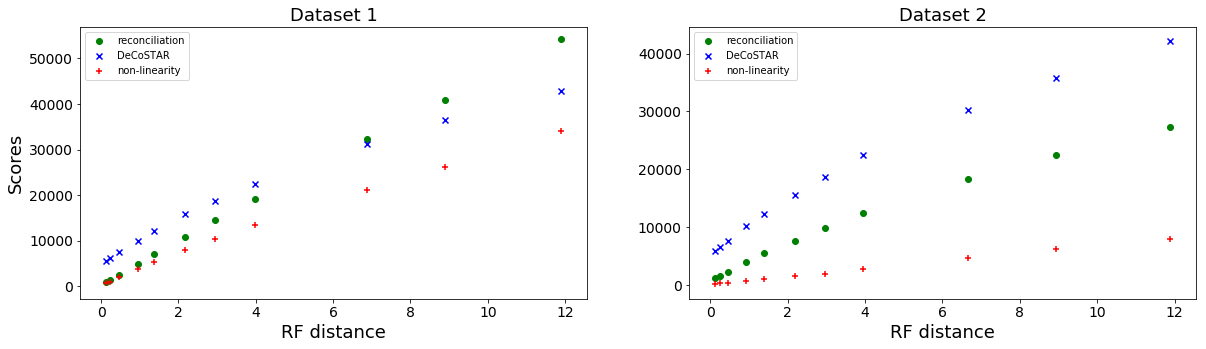

In [6]:
# Figure 3: Scores with true species tree

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(DATASET1_SUMMARY['RF'], DATASET1_SUMMARY['rec_score'], c='g', marker='o')
ax[0].scatter(DATASET1_SUMMARY['RF'], DATASET1_SUMMARY['DeCo_score'], c='b', marker='x')
ax[0].scatter(DATASET1_SUMMARY['RF'], DATASET1_SUMMARY['linearity_score'], c='r', marker='+')
ax[0].set_xlabel('RF distance', fontsize=18)
ax[0].set_ylabel('Scores', fontsize=18)
ax[0].legend(['reconciliation','DeCoSTAR','non-linearity'],loc=2)
ax[0].set_title('Dataset 1', fontsize=18)

ax[1].scatter(DATASET2_SUMMARY['RF'], DATASET2_SUMMARY['rec_score'], c='g', marker='o')
ax[1].scatter(DATASET2_SUMMARY['RF'], DATASET2_SUMMARY['DeCo_score'], c='b', marker='x')
ax[1].scatter(DATASET2_SUMMARY['RF'], DATASET2_SUMMARY['linearity_score'], c='r', marker='+')
ax[1].set_xlabel('RF distance', fontsize=18)
ax[1].legend(['reconciliation','DeCoSTAR','non-linearity'],loc=2)
ax[1].set_title('Dataset 2', fontsize=18)

plt.savefig('PAPER/SCORES.png')

plt.show()

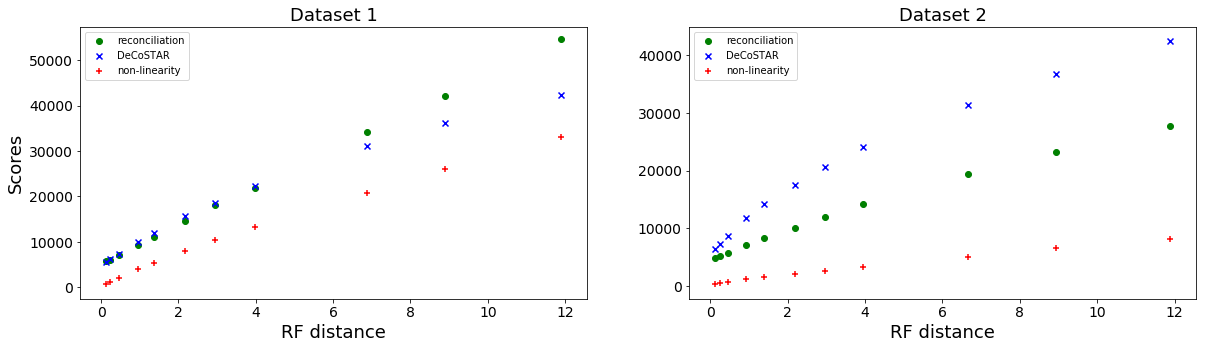

In [7]:
# Figure 8: Scores with modified species tree

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(DATASET1_ST1_SUMMARY['RF'], DATASET1_ST1_SUMMARY['rec_score'], c='g', marker='o')
ax[0].scatter(DATASET1_ST1_SUMMARY['RF'], DATASET1_ST1_SUMMARY['DeCo_score'], c='b', marker='x')
ax[0].scatter(DATASET1_ST1_SUMMARY['RF'], DATASET1_ST1_SUMMARY['linearity_score'], c='r', marker='+')
ax[0].set_xlabel('RF distance', fontsize=18)
ax[0].set_ylabel('Scores', fontsize=18)
ax[0].legend(['reconciliation','DeCoSTAR','non-linearity'],loc=2)
ax[0].set_title('Dataset 1', fontsize=18)

ax[1].scatter(DATASET2_ST1_SUMMARY['RF'], DATASET2_ST1_SUMMARY['rec_score'], c='g', marker='o')
ax[1].scatter(DATASET2_ST1_SUMMARY['RF'], DATASET2_ST1_SUMMARY['DeCo_score'], c='b', marker='x')
ax[1].scatter(DATASET2_ST1_SUMMARY['RF'], DATASET2_ST1_SUMMARY['linearity_score'], c='r', marker='+')
ax[1].set_xlabel('RF distance', fontsize=18)
ax[1].legend(['reconciliation','DeCoSTAR','non-linearity'],loc=2)
ax[1].set_title('Dataset 2', fontsize=18)

plt.savefig('PAPER/SCORES_ST1.png')

plt.show()

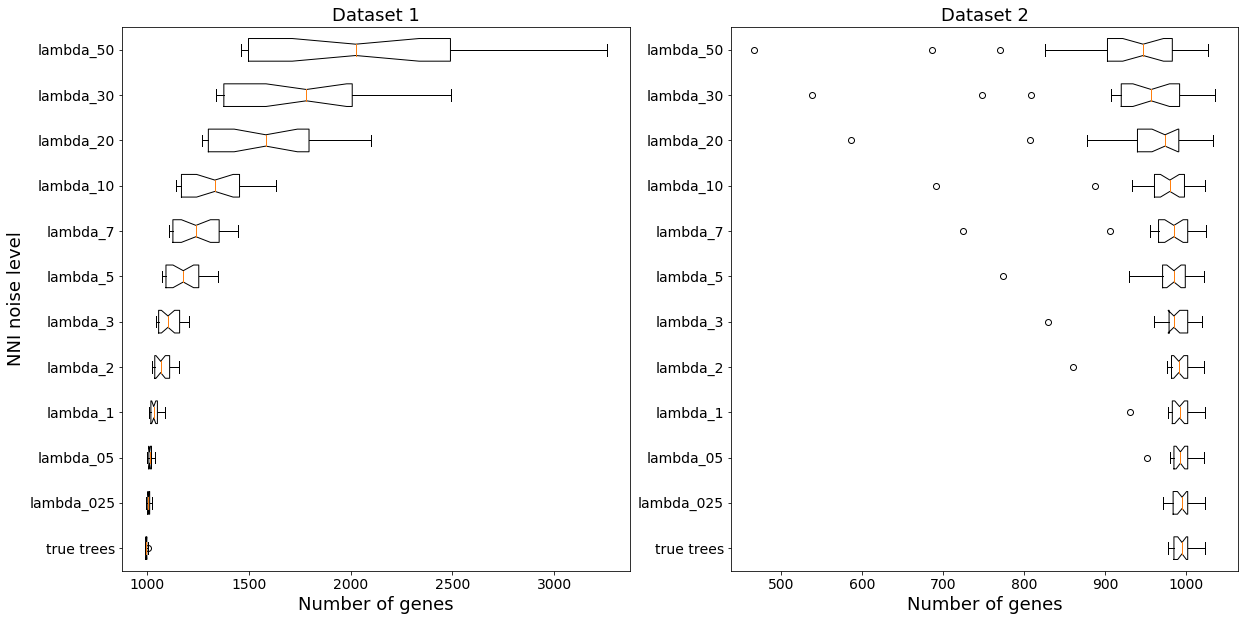

In [8]:
# Figure 4: gene content boxplot

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].boxplot(DATASET1_GENECONTENT_2D, vert=False, notch=True)
ax[0].set_yticklabels(TLAMBDA)
ax[0].set_xlabel('Number of genes', fontsize=18)
ax[0].set_ylabel('NNI noise level', fontsize=18)
ax[0].set_title('Dataset 1', fontsize=18)

ax[1].boxplot(DATASET2_GENECONTENT_2D, vert=False, notch=True)
ax[1].set_yticklabels(TLAMBDA)
ax[1].set_xlabel('Number of genes', fontsize=18)
ax[1].set_title('Dataset 2', fontsize=18)

plt.savefig('PAPER/GENE_CONTENT.png')

plt.show()

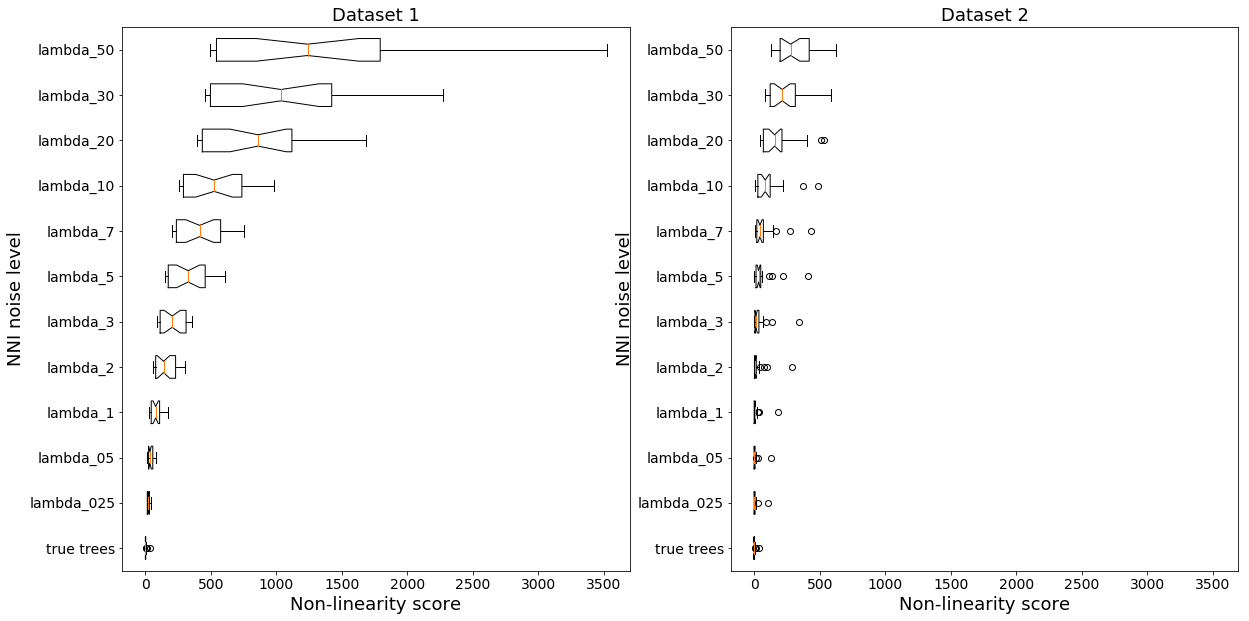

In [9]:
# Figure 7: non-linearity score boxplot

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

ax[0].boxplot(DATASET1_LINEARITY_2D, vert=False, notch=True)
ax[0].set_yticklabels(TLAMBDA)
ax[0].set_xlabel('Non-linearity score', fontsize=18)
ax[0].set_ylabel('NNI noise level', fontsize=18)
ax[0].set_title('Dataset 1', fontsize=18)


ax[1].boxplot(DATASET2_LINEARITY_2D, vert=False, notch=True)
ax[1].set_yticklabels(TLAMBDA)
ax[1].set_xlabel('Non-linearity score', fontsize=18)
ax[1].set_ylabel('NNI noise level', fontsize=18)
ax[1].set_title('Dataset 2', fontsize=18)

plt.savefig('PAPER/LINEARITY.png')

plt.show()

In [10]:
# Figures 5 and 6: linearity for Dataset 1 and 2 and lambda = 0.25, 0.5, 1

LAMBDA=['lambda_025','lambda_05','lambda_1']
EXPS={'2018_07_15_D10T0L20I10T10_NNI_DECOSTAR': 'DATASET1','2018_07_16_D10T10L20I10T10_NNI_DECOSTAR': 'DATASET2'}

for exp in EXPS.keys():
    for l in LAMBDA:
        OUT_PREF = 'PAPER/'+EXPS[exp]+'_LINEARITY_TREE'+'_'+l
        OUT_NAME = OUT_PREF+'.png'
        print(OUT_NAME)
        IN_PREF='../../exp/'+exp+'/results/DeCoSTAR/'+l+'/'+l
        TreeConflict.CreateConflictGraphics(IN_PREF,OUT_PREF)

PAPER/DATASET1_LINEARITY_TREE_lambda_025.png
PAPER/DATASET1_LINEARITY_TREE_lambda_05.png
PAPER/DATASET1_LINEARITY_TREE_lambda_1.png
PAPER/DATASET2_LINEARITY_TREE_lambda_025.png
PAPER/DATASET2_LINEARITY_TREE_lambda_05.png
PAPER/DATASET2_LINEARITY_TREE_lambda_1.png


In [11]:
# Figure 9: linearity for Dataset 1 with true gene trees 

TreeConflict.CreateConflictGraphics('../../decostar_instances/results/notransfers_true_trees','PAPER/DATASET1_TRUETREES_LINEARITY_TREE')
TreeConflict.CreateConflictGraphics('../../decostar_instances/results/notransfers_true_trees_wrong_species','PAPER/DATASET1_TRUETREES_ST1_LINEARITY_TREE')


In [12]:
# Figures 10 and 11: linearity for Dataset 1 and 2 and lambda = 0.25, 0.5, 1 and modified species tree

LAMBDA=['lambda_025','lambda_05','lambda_1']
EXPS={'2018_08_09_D10T0L20I10T10_NNI_DECOSTAR_ST1': 'DATASET1','2018_08_09_D10T10L20I10T10_NNI_DECOSTAR_ST1': 'DATASET2'}

for exp in EXPS.keys():
    for l in LAMBDA:
        OUT_PREF = 'PAPER/'+EXPS[exp]+'_LINEARITY_TREE_ST1'+'_'+l
        OUT_NAME = OUT_PREF+'.png'
        print(OUT_NAME)
        IN_PREF='../../exp/'+exp+'/results/DeCoSTAR/'+l+'/'+l
        TreeConflict.CreateConflictGraphics(IN_PREF,OUT_PREF)

PAPER/DATASET1_LINEARITY_TREE_ST1_lambda_025.png
PAPER/DATASET1_LINEARITY_TREE_ST1_lambda_05.png
PAPER/DATASET1_LINEARITY_TREE_ST1_lambda_1.png
PAPER/DATASET2_LINEARITY_TREE_ST1_lambda_025.png
PAPER/DATASET2_LINEARITY_TREE_ST1_lambda_05.png
PAPER/DATASET2_LINEARITY_TREE_ST1_lambda_1.png
